Import libraries

In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import sklearn.model_selection as ms
from torch.utils.data import TensorDataset, DataLoader


Random seed for reproducibility and GPU check

In [ ]:
seed = 42
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed) 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Mount your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Hyperparameters

In [ ]:
image_size = 64*64*3
batch_size = 64 # 32,64,128,256
epochs = 10
lr =0.01 # 0.01
weight_decay = 0.002 
mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
dataset='forest_glacier' #'mount_build'

Read Train and Test datasets - Check out the images

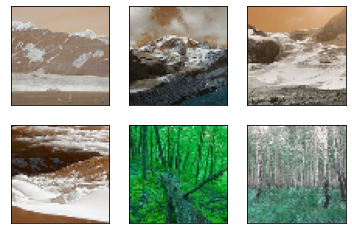

In [ ]:
if dataset =='forest_glacier':
  train_path='/content/drive/My Drive/WLD_AI/train/forest_glacier_train.pkl'
  test_path='/content/drive/My Drive/WLD_AI/test/forest_glacier_test.pkl'
  classes = ('forest', 'glacier') 
if dataset=='mount_build':
  train_path='/content/drive/MyDrive/WLD_AI/train/mountain_buildings_train.pkl'
  test_path='/content/drive/MyDrive/WLD_AI/test/mountain_buildings_test.pkl'
  classes = ('mountain', 'buildings') 

# Read Database 
def read_db(path):
    with open(path, 'rb') as handle:
      images  = pickle.load(handle)
      classes = pickle.load(handle)
    return images, classes

# Read Train set
images_train, classes_train = read_db(train_path)

# Read Test Set
images_test, classes_test = read_db(test_path)

# Show some of the images
for ii in range(6):
    plt.subplot(2, 3, ii + 1)
    rand_im = np.random.randint(0, len(images_test))
    im = images_test[rand_im]
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])

**preparing data:** Spliting trainset to train set 80% and validation set 20%, include shuffling.

In [ ]:
#  split train data to train and validation + shuffle
# -------------------------------------------------------
from sklearn.model_selection import train_test_split
val_pct = 0.2  # set percentage for validation split
random_state = 42  # random seed for reproducibility
# Shuffle data, very important!
x_train, x_val, y_train, y_val = train_test_split(images_train, classes_train, test_size=val_pct, random_state=random_state, stratify=classes_train, shuffle=True)

# transform to torch tensor
tensor_x_train = torch.Tensor(x_train) 
tensor_y_train = torch.Tensor(y_train) 
tensor_x_val = torch.Tensor(x_val) 
tensor_y_val = torch.Tensor(y_val) 

# create your datset
train_set = TensorDataset(tensor_x_train,tensor_y_train)
val_set = TensorDataset(tensor_x_val,tensor_y_val) 

# DataLoaders for iter through data
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True,num_workers=1)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=1)

#  Test data
tensor_x_test = torch.Tensor(images_test) # transform to torch tensor
tensor_y_test = torch.Tensor(classes_test) # transform to torch tensor
test_set = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_loader = DataLoader(test_set ,batch_size=len(images_test))

In [ ]:
# Defining the model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1984, 2)
        )

    def forward(self, x):
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
   
        # fc layer
        x = self.fc_layer(x)
        return x

In [ ]:
# create an instance of our model
cnn = CNN().to(device)
print(cnn)

# loss criterion
criterion = nn.CrossEntropyLoss()

# optimizer type
optimizer = optim.Adam(cnn.parameters(), lr=lr, weight_decay=weight_decay) 

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1984, out_features=2, bias=True)
  )
)


**Training the model**

In [ ]:
# training
# =========
train_losses, train_accuracy, val_losses, val_accuracy = ([] for i in range(4))  # create four empty lists
cnn.train()
for epoch in range(epochs):  # loop over the dataset multiple times
    loss = 0
    batch_accuracy = 0

    # iterate over the data
    for batch_idx, (data, labels) in enumerate(train_loader):
        labels = labels.type(torch.LongTensor)
        data, labels = data.to(device) , labels.to(device)  # move flattened data to the GPU (when using a GPU) 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(data)
        batch_loss = criterion(outputs, labels)
        batch_loss.backward()
        optimizer.step()

        # batch accuracy calculation
        # acc = number of correct predictions divded by total number of predictions
        loss += batch_loss.item() # sum up batch loss
        y_pred = torch.max(outputs.data, 1)[1]
        batch_accuracy += (y_pred == labels).sum()  # compare labels with estimation and sum up to get total number of true predictions
        
    # Normalizing the loss by the total number of train batches
    num_batches = len(train_loader)
    train_losses.append(loss/num_batches)
    # Normalizing accuracy by number of batches
    train_accuracy.append(100*batch_accuracy/len(train_set)) 
    
    # validation
    # ===========
    num_val_batches = len(val_loader)
    cnn.eval()    # will notify all layers are in eval mode, that way, relevant layers will work in eval mode instead of training mode
    val_loss = 0
    val_batch_acc = 0
  
    with torch.no_grad(): # torch.no_grad() impacts the autograd engine and deactivate it.
                          # It will reduce memory usage and speed up computations
        for batch_idx, (data, labels) in enumerate(val_loader):
            labels = labels.type(torch.LongTensor)
            data, labels = data.to(device), labels.to(device)
            # forward pass
            outputs = cnn(data)
            # accuracy & loss
            val_loss += criterion(outputs,labels).item()
            y_pred = torch.max(outputs.data, 1)[1]  
            val_batch_acc+=(y_pred == labels).sum() # compare labels with estimation
    
    val_losses.append(val_loss/num_val_batches)
    val_accuracy.append(100*val_batch_acc/len(val_set))
   
    #print for each epoch 
    print("Epoch: {0} | Training Loss: {1} | Train accuracy: {2}% | Val Loss: {3} | Val Accuracy: {4}%".format(epoch+1, train_losses[-1], train_accuracy[-1], val_losses[-1],val_accuracy[-1]))

#print final statistics
print("Final Train Loss: {1} | Final Train Accuracy: {2}% | Final Val Loss: {3} | Final Val Accuracy: {4}%".format(epoch+1, train_losses[-1], train_accuracy[-1], val_losses[-1],val_accuracy[-1]))
print('Finished Training')

Epoch: 1 | Training Loss: 2.151376901794288 | Train accuracy: 88.5828857421875% | Val Loss: 0.6102155198653539 | Val Accuracy: 91.97860717773438%
Epoch: 2 | Training Loss: 1.3123178923407854 | Train accuracy: 90.45454406738281% | Val Loss: 0.7098800202210744 | Val Accuracy: 93.26203155517578%
Epoch: 3 | Training Loss: 0.45055237791295777 | Train accuracy: 93.02139282226562% | Val Loss: 0.25115283677975336 | Val Accuracy: 94.22460174560547%
Epoch: 4 | Training Loss: 0.15598099091548032 | Train accuracy: 95.21390533447266% | Val Loss: 0.235087114572525 | Val Accuracy: 93.79679107666016%
Epoch: 5 | Training Loss: 0.14056855043933048 | Train accuracy: 95.74866485595703% | Val Loss: 0.18354607596993447 | Val Accuracy: 94.22460174560547%
Epoch: 6 | Training Loss: 0.1280558346060373 | Train accuracy: 95.90908813476562% | Val Loss: 0.18050687859455744 | Val Accuracy: 94.11764526367188%
Epoch: 7 | Training Loss: 0.11968661151763241 | Train accuracy: 95.88235473632812% | Val Loss: 0.187840253363

In [ ]:
#Testing the model on testset
test_acc = 0
total = 0
lbls_predict=[]
img_test=[]

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device) , labels.to(device)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        lbls_predict.append(predicted)
        img_test.append(images)
        total += labels.size(0)
        test_acc += (predicted == labels).sum().item() # compare labels with estimation

print('Accuracy of the CNN model on  test images: %d %%' % (100 * test_acc / total))

Accuracy of the CNN model on  test images: 96 %


**Visualize features with a scatter plot**


In [ ]:
from sklearn.manifold import TSNE
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
images_t=np.reshape(images_test, (-1,12288))
tsne_proj = tsne.fit_transform(images_t)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1027 samples in 1.099s...
[t-SNE] Computed neighbors for 1027 samples in 26.480s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1027
[t-SNE] Computed conditional probabilities for sample 1027 / 1027
[t-SNE] Mean sigma: 1779.692881
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.713615
[t-SNE] KL divergence after 1000 iterations: 1.450160


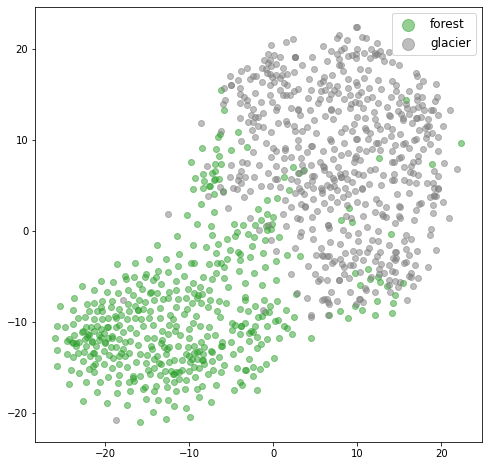

In [ ]:
#choose color palette
from matplotlib.colors import ListedColormap

green = np.asarray(plt.get_cmap("tab10").colors[2])
gray = np.asarray(plt.get_cmap("tab10").colors[7])
brown = np.asarray(plt.get_cmap("tab10").colors[5])

if dataset=='forest_glacier' :
  newcolors = np.vstack((green,gray))
else : newcolors = np.vstack((brown,gray)) 

newcmp = ListedColormap(newcolors)

fig, ax = plt.subplots(figsize=(8,8))
num_categories = 2
for lab in range(num_categories):
    indices = predicted==lab
    ax.scatter(tsne_proj[indices.cpu(),0],tsne_proj[indices.cpu(),1],  c=np.array(newcmp(lab)).reshape(1,4), label = classes[lab] ,alpha=0.5)

ax.legend(fontsize='large', markerscale=2)
plt.show()

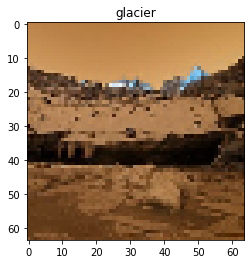

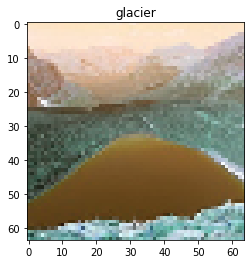

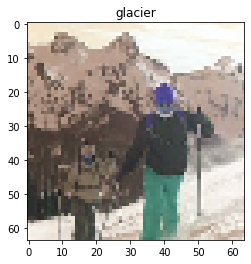

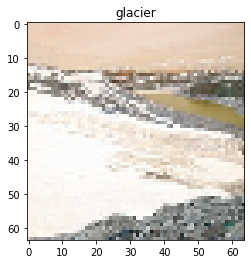

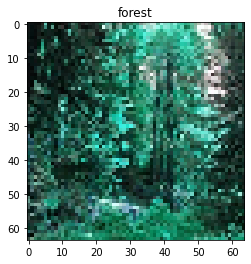

In [ ]:
# Visual Check of Predictions on testset
# ----------------------------
pred = predicted.cpu() #move predictions to cpu 
x_test_arr = np.array(images_test) 

def plot_image(X, title, ax):
    ax.imshow(X, cmap='gray')
    ax.axis('off') # hide the axes ticks
    ax.set_title(title, color = 'black', fontsize=10)

for i in range(5):
    rand=np.random.randint(low=0, high=pred.size(), size=5) #chose random images from test set
    image = x_test_arr[rand[i],:]  # image
    plt.imshow(image)
    plt.title(classes[pred[rand[i]]])
    plt.show()

plt.show()